In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import os 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from tqdm.auto import tqdm
from sklearn.model_selection import  train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc as auc_simple


In [2]:
data = 'car-price-data.csv'
df = pd.read_csv(data)
df.rename(columns={'MSRP':"price"},inplace=True)
filtred_columns=['Make',
'Model',
'Year',
'Engine HP',
'Engine Cylinders',
'Transmission Type',
'Vehicle Style',
'highway MPG',
'city mpg',
'price']

df=df[filtred_columns]
df.columns = df.columns.str.replace(' ', '_').str.lower()

df.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,price
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


In [3]:
df.fillna(0,inplace=True)
mean_price=df['price'].mean()
df['above_average']=df['price'].apply(lambda x: 1 if x>mean_price else 0)
df = df.drop(['price'], axis=1)


In [4]:
# Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

del df_train['above_average']
del df_val['above_average']
del df_test['above_average']


In [5]:
df_train.shape[0], df_val.shape[0], df_test.shape[0]

(7148, 2383, 2383)

In [6]:
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
numerical_columns = ['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

In [7]:
for feature in numerical_columns:
    roc_auc=roc_auc_score(y_train,df_train[feature])
    # print(f"{feature} roc_auc {round(roc_auc, 3)}")
    if roc_auc < 0.5:
        #  recalculate
        roc_auc = roc_auc_score(y_train, -df_train[feature])
    print(f"{feature} roc_auc {round(roc_auc, 3)}")

year roc_auc 0.688
engine_hp roc_auc 0.917
engine_cylinders roc_auc 0.766
highway_mpg roc_auc 0.633
city_mpg roc_auc 0.673


## Question 1
engine_hp 

In [8]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical_columns + numerical_columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [9]:
val_dict = df_val[categorical_columns + numerical_columns].to_dict(orient='records')
X_val = dv.transform(val_dict)
pred_val = model.predict_proba(X_val)[:,1]

In [10]:
round(roc_auc_score(y_val,pred_val),3)

0.979

## Question 2
0.979 

In [11]:

#@ CREATING CONFUSION MATRIX:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores


#@ IMPLEMENTATION OF FUNCTION:
df_scores = confusion_matrix_dataframe(y_val, pred_val)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,654,1729,0,0
10,0.1,644,334,10,1395
20,0.2,623,201,31,1528
30,0.3,605,144,49,1585
40,0.4,590,106,64,1623
50,0.5,570,73,84,1656
60,0.6,550,51,104,1678
70,0.7,506,30,148,1699
80,0.8,464,21,190,1708
90,0.9,376,3,278,1726


In [12]:

#@ ADDING THE COLUMNS:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

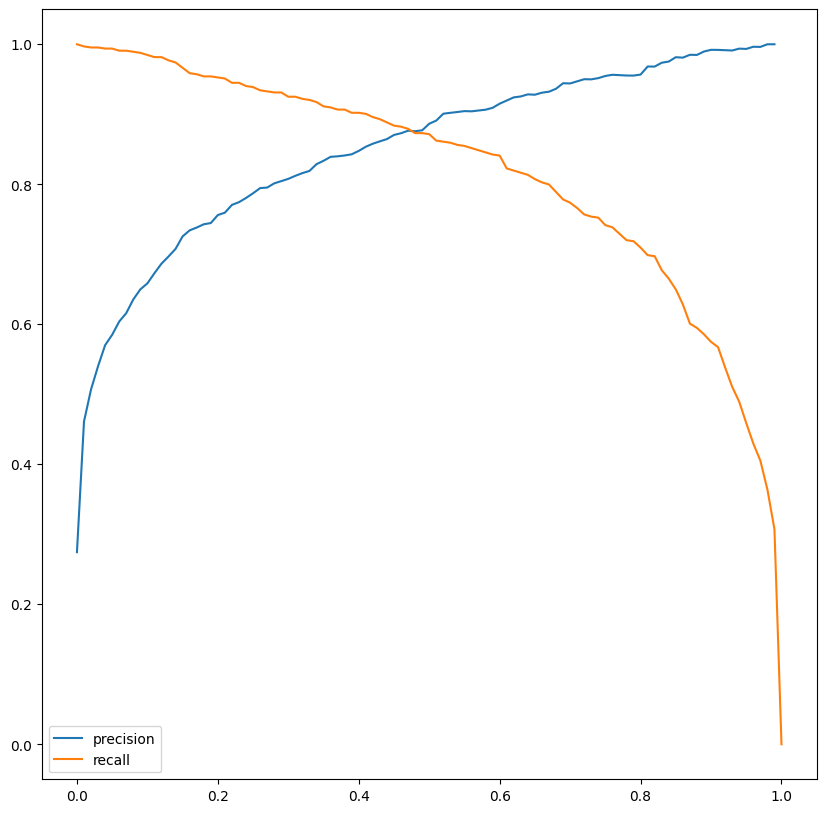

In [13]:
plt.figure(figsize=(10, 10))

#@ INSPECTING THE CURVES:
plt.plot(df_scores['threshold'], df_scores['p'], label='precision')
plt.plot(df_scores['threshold'], df_scores['r'], label='recall')

plt.legend()
plt.show()
     

## Question 3
0.48

In [14]:
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)
df_scores.loc[df_scores['f1'].idxmax()]


threshold       0.520000
tp            563.000000
fp             62.000000
fn             91.000000
tn           1667.000000
p               0.900800
r               0.860856
f1              0.880375
Name: 52, dtype: float64

In [15]:
## Question 4

0.520000

0.52

In [16]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical_columns + numerical_columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    return dv, model

def predict(df, dv, model):
    dicts = df[categorical_columns + numerical_columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [17]:
from sklearn.model_selection import KFold
scores=[]
scores2=[]

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train['above_average']
    y_val = df_val['above_average']
    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

# print(f"auc {auc} \tstd  {np.std(scores)}")
print('auc %.3f  std+- %.3f' % (np.mean(scores), np.std(scores)))

auc 0.979  std+- 0.003


## Question 5
0.003

In [18]:

for C in tqdm([0.01, 0.1, 0.5, 10]):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train['above_average']
        y_val = df_val['above_average']
        dv, model = train(df_train, y_train, C=1.0)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s auc=%.3f std+- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 auc=0.979 std+- 0.003
C=0.1 auc=0.979 std+- 0.003
C=0.5 auc=0.979 std+- 0.003
C=10 auc=0.979 std+- 0.003


## Question 6
0.01